<a href="https://colab.research.google.com/github/ShreyJ1729/EVA6-TSAI/blob/main/06-BatchNorm%26Regularization/06-BatchNorm%26Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
from model import Net

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Net("BN").to(device)
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 26, 26]             910
              ReLU-6           [-1, 10, 26, 26]               0
       BatchNorm2d-7           [-1, 10, 26, 26]              20
         Dropout2d-8           [-1, 10, 26, 26]               0
            Conv2d-9           [-1, 10, 24, 24]             910
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
        Dropout2d-12           [-1, 10, 24, 24]               0
        MaxPool2d-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 10,

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
import torch

def fit(model_name, model, device, train_loader, val_loader, optimizer, epochs, loss_func, lambda_l1=0, l1reg=None, l2reg=None, scheduler=None, notebook=False, leave=False):
    model = model.to(device)

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    if notebook:
        from tqdm.notebook import tqdm
    else:
        from tqdm import tqdm

    for epoch in range(epochs):
        model.train()
        print(f"Epoch {epoch}")
        
        epoch_results = {
            "train_loss": [],
            "train_acc": [],
        }
        epoch_losses = []
        correct = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)

            l1_loss = 0
            if l1reg is not None:
              l1 = 0
              for p in model.parameters():
                l1 = l1 + p.abs().sum()
              l1_loss = lambda_l1 * l1
              loss = loss + l1_loss
              
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # tqdm.write(f'\r[Epoch {epoch}] loss={round(sum(epoch_losses)/len(epoch_losses), 4)}', end="")
        tqdm.write('\r[Epoch {}]\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(epoch, 
            round(sum(epoch_losses)/len(epoch_losses), 4), correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))
        scheduler.step()
        
        results["train_loss"].append(round(sum(epoch_losses)/len(epoch_losses), 4))
        results["train_acc"].append(100. * correct / len(train_loader.dataset))
        
        if scheduler is not None:
          scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        tqdm.write("Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset) )
        )

        results["test_loss"].append(test_loss)
        results["test_acc"].append(100. * correct / len(test_loader.dataset) )
    
    torch.save(model, f"{model_name}.pt")
    return results

In [6]:
#Training all models

l1reg = False

final = []

for norm in ["BN", "GN", "LN"]:
  model = Net(norm).to(device)
  print(f"Training {norm} network...")
  l1reg = False
  l2reg = False
  if norm=="BN" or norm=="GN":
    l1reg = True
  if norm=="LN" or norm=="BN":
    l2reg = True
  
  if l2reg:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.85)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.85)

  results = fit(norm+"_model", model, device, train_loader, test_loader, optimizer, epochs=25, loss_func=F.nll_loss, lambda_l1 = 0.01, l1reg=l1reg, l2reg=l2reg,
                scheduler=scheduler, notebook=True, leave=True)
  final.append(results)

Training BN network...
Epoch 0



[Epoch 0]
Train set: Average loss: 3.0418, Accuracy: 44806/60000 (74.68%)
Test set: Average loss: 0.8052, Accuracy: 7395/10000 (73.95%)

Epoch 1



[Epoch 1]
Train set: Average loss: 1.7786, Accuracy: 54462/60000 (90.77%)
Test set: Average loss: 0.5469, Accuracy: 8496/10000 (84.96%)

Epoch 2



[Epoch 2]
Train set: Average loss: 1.3485, Accuracy: 54723/60000 (91.20%)
Test set: Average loss: 1.1172, Accuracy: 6412/10000 (64.12%)

Epoch 3



[Epoch 3]
Train set: Average loss: 1.2141, Accuracy: 54848/60000 (91.41%)
Test set: Average loss: 2.2443, Accuracy: 4019/10000 (40.19%)

Epoch 4



[Epoch 4]
Train set: Average loss: 1.1585, Accuracy: 55083/60000 (91.81%)
Test set: Average loss: 1.6539, Accuracy: 4993/10000 (49.93%)

Epoch 5



[Epoch 5]
Train set: Average loss: 1.0625, Accuracy: 55639/60000 (92.73%)
Test set: Average loss: 0.6809, Accuracy: 7791/10000 (77.91%)

Epoch 6



[Epoch 6]
Train set: Average loss: 0.9877, Accuracy: 55918/60000 (93.20%)
Test set: Average loss: 0.5308, Accuracy: 8456/10000 (84.56%)

Epoch 7



[Epoch 7]
Train set: Average loss: 0.9406, Accuracy: 56105/60000 (93.51%)
Test set: Average loss: 0.3800, Accuracy: 8852/10000 (88.52%)

Epoch 8



[Epoch 8]
Train set: Average loss: 0.8896, Accuracy: 56483/60000 (94.14%)
Test set: Average loss: 0.6191, Accuracy: 7847/10000 (78.47%)

Epoch 9



[Epoch 9]
Train set: Average loss: 0.8550, Accuracy: 56626/60000 (94.38%)
Test set: Average loss: 0.4308, Accuracy: 8778/10000 (87.78%)

Epoch 10



[Epoch 10]
Train set: Average loss: 0.8208, Accuracy: 56942/60000 (94.90%)
Test set: Average loss: 0.3587, Accuracy: 8932/10000 (89.32%)

Epoch 11



[Epoch 11]
Train set: Average loss: 0.7989, Accuracy: 57031/60000 (95.05%)
Test set: Average loss: 0.1525, Accuracy: 9645/10000 (96.45%)

Epoch 12



[Epoch 12]
Train set: Average loss: 0.7771, Accuracy: 57163/60000 (95.27%)
Test set: Average loss: 0.5302, Accuracy: 8167/10000 (81.67%)

Epoch 13



[Epoch 13]
Train set: Average loss: 0.7594, Accuracy: 57284/60000 (95.47%)
Test set: Average loss: 0.1266, Accuracy: 9690/10000 (96.90%)

Epoch 14



[Epoch 14]
Train set: Average loss: 0.7470, Accuracy: 57418/60000 (95.70%)
Test set: Average loss: 0.0971, Accuracy: 9756/10000 (97.56%)

Epoch 15



[Epoch 15]
Train set: Average loss: 0.7333, Accuracy: 57533/60000 (95.89%)
Test set: Average loss: 0.1827, Accuracy: 9501/10000 (95.01%)

Epoch 16



[Epoch 16]
Train set: Average loss: 0.7214, Accuracy: 57604/60000 (96.01%)
Test set: Average loss: 0.0975, Accuracy: 9791/10000 (97.91%)

Epoch 17



[Epoch 17]
Train set: Average loss: 0.7116, Accuracy: 57723/60000 (96.20%)
Test set: Average loss: 0.0958, Accuracy: 9759/10000 (97.59%)

Epoch 18



[Epoch 18]
Train set: Average loss: 0.7054, Accuracy: 57808/60000 (96.35%)
Test set: Average loss: 0.0855, Accuracy: 9806/10000 (98.06%)

Epoch 19



[Epoch 19]
Train set: Average loss: 0.6980, Accuracy: 57866/60000 (96.44%)
Test set: Average loss: 0.0853, Accuracy: 9806/10000 (98.06%)

Epoch 20



[Epoch 20]
Train set: Average loss: 0.6945, Accuracy: 57899/60000 (96.50%)
Test set: Average loss: 0.0789, Accuracy: 9806/10000 (98.06%)

Epoch 21



[Epoch 21]
Train set: Average loss: 0.6892, Accuracy: 57980/60000 (96.63%)
Test set: Average loss: 0.0771, Accuracy: 9820/10000 (98.20%)

Epoch 22



[Epoch 22]
Train set: Average loss: 0.6895, Accuracy: 57929/60000 (96.55%)
Test set: Average loss: 0.0808, Accuracy: 9836/10000 (98.36%)

Epoch 23



[Epoch 23]
Train set: Average loss: 0.6861, Accuracy: 57997/60000 (96.66%)
Test set: Average loss: 0.0931, Accuracy: 9797/10000 (97.97%)

Epoch 24



[Epoch 24]
Train set: Average loss: 0.6873, Accuracy: 57997/60000 (96.66%)
Test set: Average loss: 0.0802, Accuracy: 9833/10000 (98.33%)

Training GN network...
Epoch 0



[Epoch 0]
Train set: Average loss: 3.2767, Accuracy: 33729/60000 (56.22%)
Test set: Average loss: 0.6242, Accuracy: 8148/10000 (81.48%)

Epoch 1



[Epoch 1]
Train set: Average loss: 1.8385, Accuracy: 48081/60000 (80.14%)
Test set: Average loss: 0.5056, Accuracy: 8517/10000 (85.17%)

Epoch 2



[Epoch 2]
Train set: Average loss: 1.4317, Accuracy: 50708/60000 (84.51%)
Test set: Average loss: 0.3483, Accuracy: 9106/10000 (91.06%)

Epoch 3



[Epoch 3]
Train set: Average loss: 1.2750, Accuracy: 51600/60000 (86.00%)
Test set: Average loss: 0.3615, Accuracy: 9084/10000 (90.84%)

Epoch 4



[Epoch 4]
Train set: Average loss: 1.1650, Accuracy: 52694/60000 (87.82%)
Test set: Average loss: 0.3287, Accuracy: 9060/10000 (90.60%)

Epoch 5



[Epoch 5]
Train set: Average loss: 1.2334, Accuracy: 52042/60000 (86.74%)
Test set: Average loss: 0.3929, Accuracy: 8851/10000 (88.51%)

Epoch 6



[Epoch 6]
Train set: Average loss: 1.1466, Accuracy: 52763/60000 (87.94%)
Test set: Average loss: 0.2853, Accuracy: 9295/10000 (92.95%)

Epoch 7



[Epoch 7]
Train set: Average loss: 1.0612, Accuracy: 53700/60000 (89.50%)
Test set: Average loss: 0.2490, Accuracy: 9339/10000 (93.39%)

Epoch 8



[Epoch 8]
Train set: Average loss: 1.0153, Accuracy: 53999/60000 (90.00%)
Test set: Average loss: 0.2399, Accuracy: 9429/10000 (94.29%)

Epoch 9



[Epoch 9]
Train set: Average loss: 0.9753, Accuracy: 54226/60000 (90.38%)
Test set: Average loss: 0.2715, Accuracy: 9249/10000 (92.49%)

Epoch 10



[Epoch 10]
Train set: Average loss: 0.9386, Accuracy: 54535/60000 (90.89%)
Test set: Average loss: 0.2232, Accuracy: 9399/10000 (93.99%)

Epoch 11



[Epoch 11]
Train set: Average loss: 0.9045, Accuracy: 54878/60000 (91.46%)
Test set: Average loss: 0.2536, Accuracy: 9258/10000 (92.58%)

Epoch 12



[Epoch 12]
Train set: Average loss: 0.8980, Accuracy: 54732/60000 (91.22%)
Test set: Average loss: 0.2377, Accuracy: 9349/10000 (93.49%)

Epoch 13



[Epoch 13]
Train set: Average loss: 0.8846, Accuracy: 54878/60000 (91.46%)
Test set: Average loss: 0.1791, Accuracy: 9533/10000 (95.33%)

Epoch 14



[Epoch 14]
Train set: Average loss: 0.8565, Accuracy: 55181/60000 (91.97%)
Test set: Average loss: 0.1752, Accuracy: 9537/10000 (95.37%)

Epoch 15



[Epoch 15]
Train set: Average loss: 0.8278, Accuracy: 55550/60000 (92.58%)
Test set: Average loss: 0.1727, Accuracy: 9563/10000 (95.63%)

Epoch 16



[Epoch 16]
Train set: Average loss: 0.8166, Accuracy: 55585/60000 (92.64%)
Test set: Average loss: 0.1729, Accuracy: 9546/10000 (95.46%)

Epoch 17



[Epoch 17]
Train set: Average loss: 0.8022, Accuracy: 55738/60000 (92.90%)
Test set: Average loss: 0.1580, Accuracy: 9607/10000 (96.07%)

Epoch 18



[Epoch 18]
Train set: Average loss: 0.7906, Accuracy: 55854/60000 (93.09%)
Test set: Average loss: 0.1502, Accuracy: 9626/10000 (96.26%)

Epoch 19



[Epoch 19]
Train set: Average loss: 0.7829, Accuracy: 55882/60000 (93.14%)
Test set: Average loss: 0.1498, Accuracy: 9636/10000 (96.36%)

Epoch 20



[Epoch 20]
Train set: Average loss: 0.7758, Accuracy: 56006/60000 (93.34%)
Test set: Average loss: 0.1489, Accuracy: 9634/10000 (96.34%)

Epoch 21



[Epoch 21]
Train set: Average loss: 0.7693, Accuracy: 56120/60000 (93.53%)
Test set: Average loss: 0.1466, Accuracy: 9642/10000 (96.42%)

Epoch 22



[Epoch 22]
Train set: Average loss: 0.7690, Accuracy: 56010/60000 (93.35%)
Test set: Average loss: 0.1473, Accuracy: 9638/10000 (96.38%)

Epoch 23



[Epoch 23]
Train set: Average loss: 0.7637, Accuracy: 56059/60000 (93.43%)
Test set: Average loss: 0.1481, Accuracy: 9639/10000 (96.39%)

Epoch 24



[Epoch 24]
Train set: Average loss: 0.7615, Accuracy: 56119/60000 (93.53%)
Test set: Average loss: 0.1452, Accuracy: 9649/10000 (96.49%)

Training LN network...
Epoch 0



[Epoch 0]
Train set: Average loss: 201.9190, Accuracy: 33338/60000 (55.56%)
Test set: Average loss: 0.8556, Accuracy: 6947/10000 (69.47%)

Epoch 1



[Epoch 1]
Train set: Average loss: 96.1765, Accuracy: 46208/60000 (77.01%)
Test set: Average loss: 0.5345, Accuracy: 8491/10000 (84.91%)

Epoch 2



[Epoch 2]
Train set: Average loss: 22.3429, Accuracy: 47918/60000 (79.86%)
Test set: Average loss: 0.7310, Accuracy: 7795/10000 (77.95%)

Epoch 3



[Epoch 3]
Train set: Average loss: 2.1523, Accuracy: 46935/60000 (78.22%)
Test set: Average loss: 0.6861, Accuracy: 8251/10000 (82.51%)

Epoch 4



[Epoch 4]
Train set: Average loss: 1.8617, Accuracy: 48384/60000 (80.64%)
Test set: Average loss: 0.6194, Accuracy: 8363/10000 (83.63%)

Epoch 5



[Epoch 5]
Train set: Average loss: 1.7526, Accuracy: 49266/60000 (82.11%)
Test set: Average loss: 0.5423, Accuracy: 8570/10000 (85.70%)

Epoch 6



[Epoch 6]
Train set: Average loss: 1.6531, Accuracy: 50023/60000 (83.37%)
Test set: Average loss: 0.5951, Accuracy: 8467/10000 (84.67%)

Epoch 7



[Epoch 7]
Train set: Average loss: 1.5767, Accuracy: 50390/60000 (83.98%)
Test set: Average loss: 0.5083, Accuracy: 8758/10000 (87.58%)

Epoch 8



[Epoch 8]
Train set: Average loss: 1.5219, Accuracy: 50799/60000 (84.67%)
Test set: Average loss: 0.4906, Accuracy: 8781/10000 (87.81%)

Epoch 9



[Epoch 9]
Train set: Average loss: 1.4651, Accuracy: 51433/60000 (85.72%)
Test set: Average loss: 0.4731, Accuracy: 8808/10000 (88.08%)

Epoch 10



[Epoch 10]
Train set: Average loss: 1.4164, Accuracy: 51786/60000 (86.31%)
Test set: Average loss: 0.4277, Accuracy: 8923/10000 (89.23%)

Epoch 11



[Epoch 11]
Train set: Average loss: 1.3753, Accuracy: 52143/60000 (86.91%)
Test set: Average loss: 0.4211, Accuracy: 8986/10000 (89.86%)

Epoch 12



[Epoch 12]
Train set: Average loss: 1.3443, Accuracy: 52265/60000 (87.11%)
Test set: Average loss: 0.3744, Accuracy: 9108/10000 (91.08%)

Epoch 13



[Epoch 13]
Train set: Average loss: 1.3124, Accuracy: 52547/60000 (87.58%)
Test set: Average loss: 0.3907, Accuracy: 9087/10000 (90.87%)

Epoch 14



[Epoch 14]
Train set: Average loss: 1.2833, Accuracy: 52962/60000 (88.27%)
Test set: Average loss: 0.3594, Accuracy: 9179/10000 (91.79%)

Epoch 15



[Epoch 15]
Train set: Average loss: 1.2621, Accuracy: 53091/60000 (88.48%)
Test set: Average loss: 0.3580, Accuracy: 9155/10000 (91.55%)

Epoch 16



[Epoch 16]
Train set: Average loss: 1.2446, Accuracy: 53325/60000 (88.88%)
Test set: Average loss: 0.3542, Accuracy: 9177/10000 (91.77%)

Epoch 17



[Epoch 17]
Train set: Average loss: 1.2328, Accuracy: 53342/60000 (88.90%)
Test set: Average loss: 0.3515, Accuracy: 9210/10000 (92.10%)

Epoch 18



[Epoch 18]
Train set: Average loss: 1.2214, Accuracy: 53497/60000 (89.16%)
Test set: Average loss: 0.3431, Accuracy: 9220/10000 (92.20%)

Epoch 19



[Epoch 19]
Train set: Average loss: 1.2030, Accuracy: 53745/60000 (89.58%)
Test set: Average loss: 0.3432, Accuracy: 9189/10000 (91.89%)

Epoch 20



[Epoch 20]
Train set: Average loss: 1.2010, Accuracy: 53721/60000 (89.53%)
Test set: Average loss: 0.3295, Accuracy: 9244/10000 (92.44%)

Epoch 21



[Epoch 21]
Train set: Average loss: 1.1930, Accuracy: 53875/60000 (89.79%)
Test set: Average loss: 0.3271, Accuracy: 9258/10000 (92.58%)

Epoch 22



[Epoch 22]
Train set: Average loss: 1.1897, Accuracy: 53851/60000 (89.75%)
Test set: Average loss: 0.3277, Accuracy: 9239/10000 (92.39%)

Epoch 23



[Epoch 23]
Train set: Average loss: 1.1858, Accuracy: 53949/60000 (89.92%)
Test set: Average loss: 0.3249, Accuracy: 9255/10000 (92.55%)

Epoch 24



[Epoch 24]
Train set: Average loss: 1.1813, Accuracy: 53925/60000 (89.88%)
Test set: Average loss: 0.3227, Accuracy: 9248/10000 (92.48%)



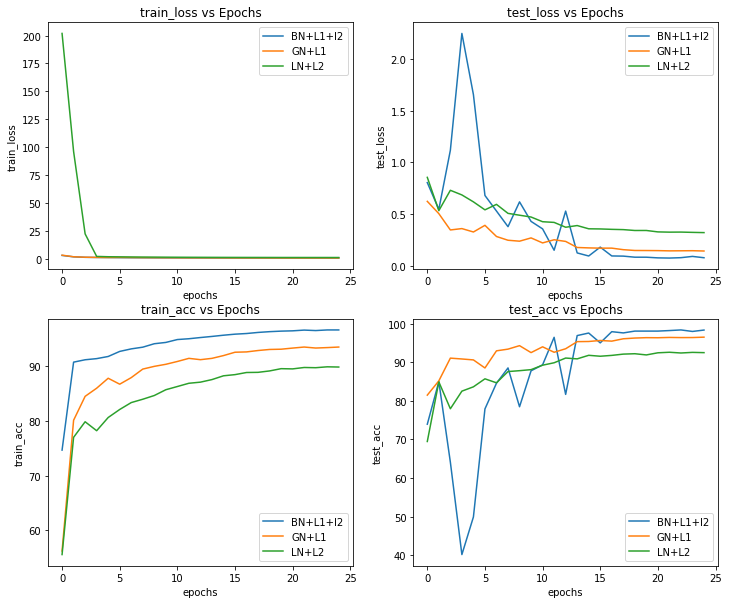

In [78]:
# Test loss plot:
# 0 - BN+L1
# 1 - GN
# 2 - LN

import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
index=1
for metric in ["train_loss", "test_loss", "train_acc", "test_acc"]:
  plt.subplot(2, 2, index)
  plt.plot(final[0][metric], label="BN+L1+l2")
  plt.plot(final[1][metric], label="GN+L1")
  plt.plot(final[2][metric], label="LN+L2")
  plt.legend()
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.title(f"{metric} vs Epochs")
  index+=1
plt.show()

Misclassified images for BN_model:


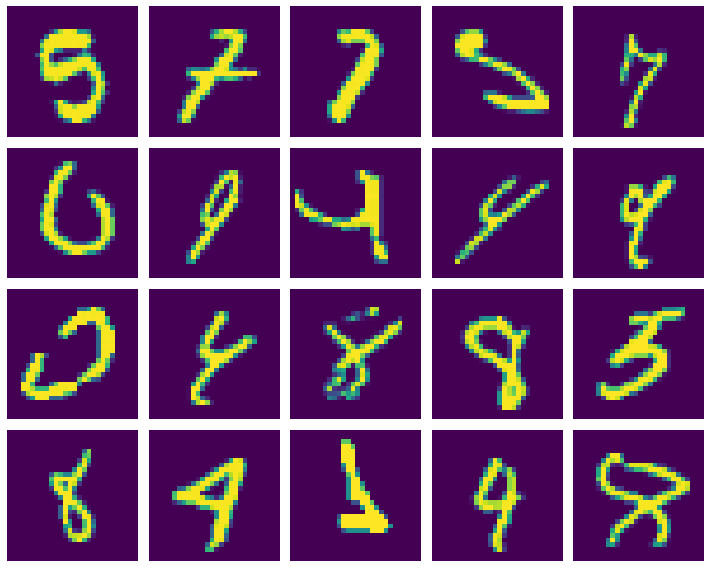

Misclassified images for GN_model:


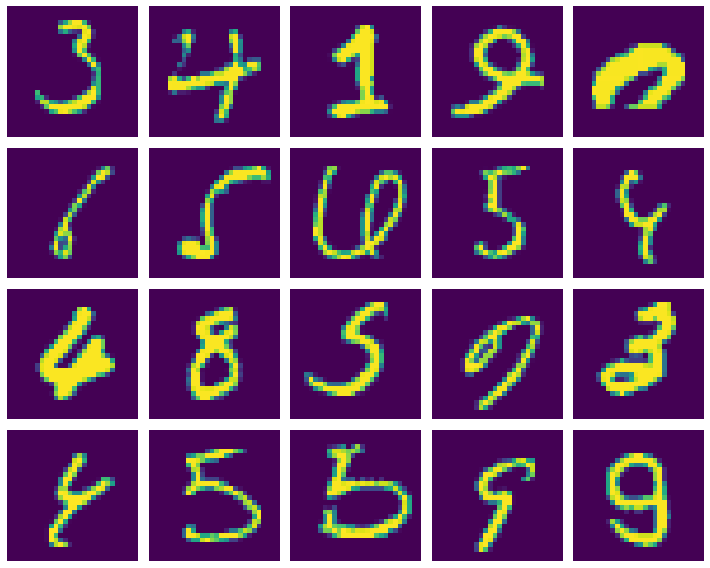

Misclassified images for LN_model:


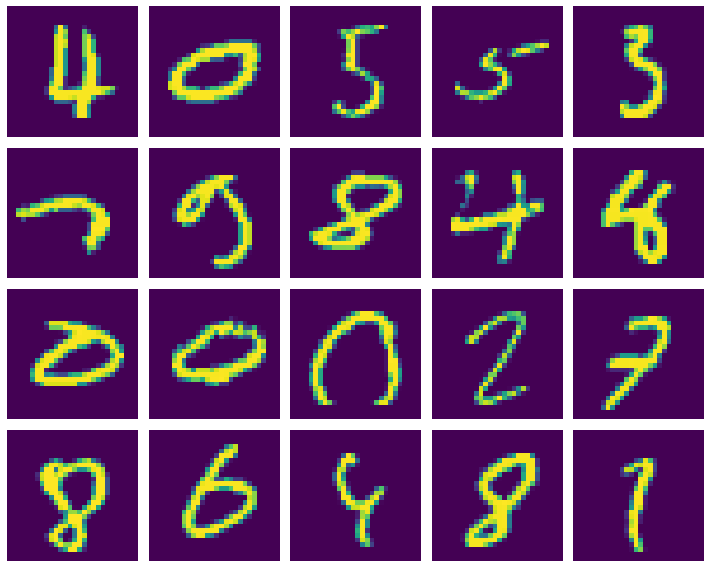

In [101]:
for path in ["BN_model.pt", "GN_model.pt", "LN_model.pt"]:
  model = torch.load(path)
  count = 0
  badimages = []
  badpreds = []
  badlabels = []
  for (data, labels) in test_loader:
    data = data.to(device)
    preds = model(data).cpu()
    preds = torch.argmax(preds, 1)
    matches = preds.eq(labels)
    for i in range(len(matches)):
      if matches[i]==False:
        count+=1
        badimages.append(data[i])
        badpreds.append(preds[i])
        badlabels.append(labels[i])
      if count==20: break
    if count==20: break
  
  print(f"Misclassified images for {path.split('.')[0]}:")
  plt.figure(figsize=(10, 8))
  for idx, image in enumerate(badimages):
    plt.subplot(4, 5, idx+1)
    plt.axis("off")
    plt.imshow(image.cpu()[0])
  plt.tight_layout()
  plt.show()